In [1]:
!pip install matplotlib

In [82]:
import pandas as pd
import os
from pathlib import Path
import re
import sqlite3
import requests
from functools import reduce
import matplotlib.pyplot as plt
import geopandas as gpd

pd.set_option('display.max_columns', None)

In [3]:
stasiun_mapping = {
    'DKI1': 'Jakarta Pusat',
    'DKI2': 'Jakarta Utara',
    'DKI3': 'Jakarta Selatan',
    'DKI4': 'Jakarta Timur',
    'DKI5': 'Jakarta Barat'
}

In [4]:
# Define column mapping to match data.md convention
column_mapping = {
    'pm10': 'pm_sepuluh',
    'so2': 'sulfur_dioksida',
    'co': 'karbon_monoksida',
    'o3': 'ozon',
    'no2': 'nitrogen_dioksida',
    'critical': 'parameter_pencemar_kritis',
    'categori': 'kategori',
    'lokasi_spku': 'stasiun'
}

# Define column order to match data.md
column_order = [
    'periode_data', 'tanggal', 'stasiun', 'pm_sepuluh',
    'sulfur_dioksida', 'karbon_monoksida', 'ozon', 'nitrogen_dioksida',
    'max', 'parameter_pencemar_kritis', 'kategori'
]


final_year = 2019

# Define the folder path and years to combine
ispu_folder = Path("data/ISPU")
years_to_combine = [i for i in range(2015, final_year + 1, 1)]

# List to store dataframes
dfs = []

# Load and standardize files that contain the desired years
for file_path in ispu_folder.glob("*.csv"):
    # Check if any of the desired years is in the filename
    for year in years_to_combine:
        if str(year) in file_path.name:
            df_temp = pd.read_csv(file_path)
            
            print(f"Loaded: {file_path.name}")
            print(f"  Original columns: {list(df_temp.columns)}")
            
            # Rename columns to match convention
            df_temp = df_temp.rename(columns=column_mapping)
            
            # Add missing columns with None
            for col in column_order:
                if col not in df_temp.columns:
                    df_temp[col] = None
            
            # Reorder columns to match data.md
            df_temp = df_temp[column_order]
            
            print(f"  Standardized to: {list(df_temp.columns)}")
            print(f"  Rows: {len(df_temp)}\n")
            
            dfs.append(df_temp)
            break

print(f"Total files loaded: {len(dfs)}")

# Combine all dataframes
df_combined = pd.concat(dfs, ignore_index=True)

Loaded: indeks-standar-pencemaran-udara-(ispu)-tahun-2018-komponen-data.csv
  Original columns: ['periode_data', 'tanggal', 'pm10', 'so2', 'co', 'o3', 'no2', 'max', 'critical', 'categori', 'lokasi_spku']
  Standardized to: ['periode_data', 'tanggal', 'stasiun', 'pm_sepuluh', 'sulfur_dioksida', 'karbon_monoksida', 'ozon', 'nitrogen_dioksida', 'max', 'parameter_pencemar_kritis', 'kategori']
  Rows: 365

Loaded: indeks-standar-pencemaran-udara-(ispu)-tahun-2019-komponen-data.csv
  Original columns: ['periode_data', 'tanggal', 'pm10', 'so2', 'co', 'o3', 'no2', 'max', 'critical', 'categori', 'lokasi_spku']
  Standardized to: ['periode_data', 'tanggal', 'stasiun', 'pm_sepuluh', 'sulfur_dioksida', 'karbon_monoksida', 'ozon', 'nitrogen_dioksida', 'max', 'parameter_pencemar_kritis', 'kategori']
  Rows: 345

Loaded: indeks-standar-pencemaran-udara-(ispu)-tahun-2016-komponen-data.csv
  Original columns: ['periode_data', 'tanggal', 'stasiun', 'pm10', 'so2', 'co', 'o3', 'no2', 'max', 'critical', 'c

In [5]:
# Replace empty strings and "---" with NULL (NaN)
df_combined = df_combined.replace(['', '---', ' ', '  '], pd.NA)
df_combined = df_combined[df_combined['kategori'] != 'TIDAK ADA DATA']

df_combined['tanggal'] = pd.to_datetime(
    df_combined['tanggal'], 
    format='mixed',  # Allows multiple formats
    dayfirst=False,  # Month comes first in ambiguous cases
    errors='raise'
)

# Convert pollutant columns to integers (pd.NA will remain as NaN for nullable Int64)
numeric_columns = ['pm_sepuluh', 'sulfur_dioksida', 
                   'karbon_monoksida', 'ozon', 'nitrogen_dioksida', 'max']

for col in numeric_columns:
    df_combined[col] = pd.to_numeric(df_combined[col], errors='coerce').astype('Int64')

In [6]:
# Function to extract station ID (DKIx format)
def extract_station_id(station_name):
    if pd.isna(station_name):
        return station_name
    # Extract DKI followed by a number
    match = re.search(r'DKI\d+', str(station_name), re.IGNORECASE)
    if match:
        return match.group(0).upper()
    return station_name

# Apply normalization to stasiun column
df_combined['stasiun'] = df_combined['stasiun'].apply(extract_station_id)

In [7]:
df_combined['ID'] = df_combined['tanggal'].astype(str) + '_' + df_combined['stasiun'].astype(str)
df_combined = df_combined[['ID'] + column_order]
df_combined = df_combined.sort_values(by=['tanggal']).reset_index(drop=True)
df_combined = df_combined.ffill()
# df_combined['kota'] = 

In [8]:
df_combined.info()

<class 'pandas.DataFrame'>
RangeIndex: 4663 entries, 0 to 4662
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ID                         4663 non-null   str           
 1   periode_data               4663 non-null   int64         
 2   tanggal                    4663 non-null   datetime64[us]
 3   stasiun                    4663 non-null   str           
 4   pm_sepuluh                 4663 non-null   Int64         
 5   sulfur_dioksida            4663 non-null   Int64         
 6   karbon_monoksida           4663 non-null   Int64         
 7   ozon                       4663 non-null   Int64         
 8   nitrogen_dioksida          4663 non-null   Int64         
 9   max                        4663 non-null   Int64         
 10  parameter_pencemar_kritis  4663 non-null   str           
 11  kategori                   4663 non-null   str           
dtypes: Int64(6), date

In [9]:
df_combined.to_csv('data/ispu_2015-2019.csv', index=False)

In [10]:
df_combined

,ID,periode_data,tanggal,stasiun,pm_sepuluh,sulfur_dioksida,karbon_monoksida,ozon,nitrogen_dioksida,max,parameter_pencemar_kritis,kategori
0,2015-01-01_DKI1,201501,2015-01-01,DKI1,49,10,39,27,10,49,PM10,BAIK
1,2015-01-02_DKI2,201501,2015-01-02,DKI2,28,9,26,48,10,48,O3,BAIK
2,2015-01-03_DKI2,201501,2015-01-03,DKI2,27,10,28,44,10,44,O3,BAIK
3,2015-01-04_DKI2,201501,2015-01-04,DKI2,22,9,28,42,12,42,O3,BAIK
4,2015-01-05_DKI2,201501,2015-01-05,DKI2,25,9,25,32,7,32,O3,BAIK
...,...,...,...,...,...,...,...,...,...,...,...,...
4658,2019-12-27_DKI4,201912,2019-12-27,DKI4,55,38,26,84,11,84,O3,SEDANG
4659,2019-12-28_DKI2,201912,2019-12-28,DKI2,64,37,34,61,11,64,PM10,SEDANG
4660,2019-12-29_DKI5,201912,2019-12-29,DKI5,64,38,36,69,10,69,O3,SEDANG
4661,2019-12-30_DKI2,201912,2019-12-30,DKI2,77,37,55,89,9,89,O3,SEDANG


# QC

In [11]:
# Check for issues that might need cleanup
print("=== Data Quality Check ===\n")

# 1. Check for duplicate IDs
duplicates = df_combined[df_combined['ID'].duplicated(keep=False)]
print(f"Duplicate IDs: {len(duplicates)}")
if len(duplicates) > 0:
    print(duplicates[['ID', 'tanggal', 'stasiun', 'kategori']].head())

# 2. Check for missing values in key columns
print("\nMissing values in critical columns:")
print(df_combined[['ID', 'tanggal', 'stasiun', 'kategori']].isnull().sum())

# 3. Check for invalid station IDs
print("\nUnique station IDs:")
print(sorted(df_combined['stasiun'].unique()))

# 4. Check kategori values
print("\nKategori distribution:")
print(df_combined['kategori'].value_counts())

# 5. Check for invalid dates
print(f"\nInvalid dates (NaT): {df_combined['tanggal'].isna().sum()}")

# 6. Check for negative or unrealistic pollutant values
print("\nNegative pollutant values:")
for col in numeric_columns:
    neg_count = (df_combined[col] < 0).sum()
    if neg_count > 0:
        print(f"  {col}: {neg_count}")

=== Data Quality Check ===

Duplicate IDs: 345
                  ID    tanggal stasiun kategori
421  2016-01-12_DKI3 2016-01-12    DKI3     BAIK
422  2016-01-12_DKI4 2016-01-12    DKI4   SEDANG
423  2016-01-12_DKI3 2016-01-12    DKI3   SEDANG
424  2016-01-12_DKI4 2016-01-12    DKI4   SEDANG
425  2016-01-12_DKI2 2016-01-12    DKI2   SEDANG

Missing values in critical columns:
ID          0
tanggal     0
stasiun     0
kategori    0
dtype: int64

Unique station IDs:
['DKI1', 'DKI2', 'DKI3', 'DKI4', 'DKI5']

Kategori distribution:
kategori
SEDANG                2938
BAIK                   911
TIDAK SEHAT            778
SANGAT TIDAK SEHAT      36
Name: count, dtype: int64

Invalid dates (NaT): 0

Negative pollutant values:


# Data Wilayah Administrasi DKI Jakarta

In [12]:
# Load administrative region codes (optional reference)


url = "https://raw.githubusercontent.com/cahyadsn/wilayah/refs/heads/master/db/wilayah.sql"
response = requests.get(url)
response.raise_for_status()
sql_content = response.text

# Clean SQL
clean_sql = re.sub(r'^/\*.*?\*/\s*|--.*?$|ENGINE=\w+\s*|DEFAULT CHARSET=\w+\s*', '', 
                   sql_content, flags=re.DOTALL | re.MULTILINE)
clean_sql = clean_sql.replace('`', '').strip()

# Load to SQLite
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()
cursor.execute("CREATE TABLE IF NOT EXISTS wilayah (kode TEXT PRIMARY KEY, nama TEXT)")

statements = [s.strip() for s in clean_sql.split(';') if s.strip() and 'INSERT INTO' in s.upper()]
for stmt in statements[:5000]:  # Limit for efficiency
    try:
        cursor.execute(stmt)
    except:
        pass

conn.commit()
df_wilayah = pd.read_sql_query("SELECT * FROM wilayah WHERE kode LIKE '31%'", conn)
print(f"Loaded {len(df_wilayah)} DKI Jakarta administrative codes")

Loaded 318 DKI Jakarta administrative codes


# Data Kualitas Air Sungai

In [13]:
sungai = pd.read_csv('data/kualitas-air-sungai/data-kualitas-air-sungai-komponen-data.csv')

In [14]:
params_sungai = ['Kimia', 'Fisika', 'Biologi'] 

index_columns = ['periode_data', 'periode_pemantauan', 'bulan_sampling', 'titik_sampel',
       'nama_sungai', 'alamat', 'latitude', 'longitude']
parameter_columns = 'parameter'
value_columns = 'hasil_pengukuran'

In [15]:
sungai_dfs = []
for param in params_sungai:
    _sungai_df = sungai[sungai['jenis_parameter'] == param].sort_values(by=['periode_data', 'periode_pemantauan', 'bulan_sampling', 'titik_sampel'])
    _sungai_df = _sungai_df.pivot(index=index_columns, columns=parameter_columns, values=value_columns)
    # _sungai_df.columns = [f'{val}_{par}' for val, par in _sungai_df.columns]
    _sungai_df = _sungai_df.reset_index()
    print(len(_sungai_df))
    sungai_dfs.append(_sungai_df)

480
480
480


In [16]:
common_cols = ['periode_data', 'periode_pemantauan', 'bulan_sampling', 'titik_sampel', 'nama_sungai', 'alamat', 'latitude', 'longitude']

sungai_df = reduce(lambda left, right: pd.merge(left, right, on=common_cols, how='inner'), sungai_dfs)
sungai_df.columns.name = None

In [103]:
for a in sungai_df['alamat'].sort_values().unique():
    if 'mas mansyur' in a.lower():
        print(a)

Jl. KH Mas Mansyur Karet Tengsin


# Data Batas Wilayah Administrasi DKI Jakarta

In [18]:
# Helper Functions
import json
from shapely.geometry import Polygon, MultiPolygon

def parse_boundary_sql(sql_content):
    """Parse SQL file to extract boundary data."""
    lines = sql_content.split('\n')
    data = []
    
    for line in lines:
        line = line.strip()
        if line.startswith("('"):
            try:
                first_quote = line.find("'")
                second_quote = line.find("'", first_quote + 1)
                kode = line[first_quote+1:second_quote]
                
                third_quote = line.find("'", second_quote + 1)
                fourth_quote = line.find("'", third_quote + 1)
                nama = line[third_quote+1:fourth_quote]
                
                after_nama = line[fourth_quote+2:]
                parts = after_nama.split(',', 2)
                
                if len(parts) >= 3:
                    lat = parts[0].strip()
                    lng = parts[1].strip()
                    rest = parts[2]
                    path_start = rest.find("'")
                    path_end = rest.rfind("'")
                    if path_start != -1 and path_end != -1:
                        geom = rest[path_start+1:path_end]
                        data.append([kode, nama, lat, lng, geom])
            except:
                pass
    
    return pd.DataFrame(data, columns=['kode', 'nama', 'lat', 'lng', 'geom'])

def swap_coords(coord_list):
    """Recursively swap [lat,lng] to [lng,lat] for GeoJSON compatibility."""
    if isinstance(coord_list[0], (int, float)):
        return [coord_list[1], coord_list[0]]
    else:
        return [swap_coords(c) for c in coord_list]

def parse_geometry(geom_str):
    """Parse geometry string to Shapely Polygon/MultiPolygon."""
    try:
        coords = json.loads(geom_str)
        coords = swap_coords(coords)
        
        if isinstance(coords[0][0], (int, float)):
            return Polygon(coords)
        elif isinstance(coords[0][0][0], (int, float)):
            exterior = coords[0]
            holes = coords[1:] if len(coords) > 1 else []
            return Polygon(exterior, holes)
        else:
            polygons = []
            for poly_coords in coords:
                exterior = poly_coords[0]
                holes = poly_coords[1:] if len(poly_coords) > 1 else []
                polygons.append(Polygon(exterior, holes))
            return MultiPolygon(polygons)
    except Exception as e:
        print(f"Error parsing geometry: {e}")
        return None

def assign_to_nearest_region(gdf_points, gdf_boundaries, nama_col='kota_kabupaten'):
    """Assign unassigned points to nearest boundary with tie-breaking by current count."""
    unassigned_mask = gdf_points[nama_col].isna()
    unassigned_indices = gdf_points[unassigned_mask].index
    
    if len(unassigned_indices) == 0:
        return gdf_points
    
    print(f"Assigning {len(unassigned_indices)} samples to nearest boundaries...")
    current_counts = gdf_points[nama_col].value_counts().to_dict()
    
    for idx in unassigned_indices:
        point = gdf_points.loc[idx, 'geometry']
        distances = []
        
        for _, boundary_row in gdf_boundaries.iterrows():
            dist = point.distance(boundary_row['geometry'])
            nama = boundary_row['nama']
            count = current_counts.get(nama, 0)
            distances.append((dist, count, nama))
        
        distances.sort(key=lambda x: (x[0], x[1]))
        _, _, nearest_nama = distances[0]
        
        gdf_points.loc[idx, nama_col] = nearest_nama
        current_counts[nearest_nama] = current_counts.get(nearest_nama, 0) + 1
    
    return gdf_points

In [19]:
# ────────────────────────────────────────────────
# Step 1: Download the SQL file content
# ────────────────────────────────────────────────
url = "https://raw.githubusercontent.com/cahyadsn/wilayah_boundaries/refs/heads/main/db/kab/wilayah_boundaries_kab_31.sql"
response = requests.get(url)
response.raise_for_status()          # fail early if download error
sql_content = response.text

# Clean the SQL content
clean_sql = re.sub(r'^/\*.*?\*/\s*', '', sql_content, flags=re.DOTALL | re.MULTILINE).strip()

# Additional cleaning
clean_sql = re.sub(r'--.*?$', '', clean_sql, flags=re.MULTILINE)  # Remove -- comments
clean_sql = re.sub(r'ENGINE=\w+\s*', '', clean_sql, flags=re.IGNORECASE)  # Remove ENGINE
clean_sql = re.sub(r'DEFAULT CHARSET=\w+\s*', '', clean_sql, flags=re.IGNORECASE)  # Remove CHARSET
clean_sql = clean_sql.replace('`', '')  # Remove backticks

In [20]:
# Parse boundary data
df_batas_wilayah = parse_boundary_sql(clean_sql)

# Filter out Kepulauan Seribu (only keep mainland Jakarta)
df_batas_wilayah = df_batas_wilayah[df_batas_wilayah['kode'] != '31.01'].reset_index(drop=True)

print(f"Loaded {len(df_batas_wilayah)} mainland DKI Jakarta boundaries:")
print(df_batas_wilayah[['kode', 'nama']].to_string(index=False))

Loaded 5 mainland DKI Jakarta boundaries:
 kode                              nama
31.71   Kota Administrasi Jakarta Pusat
31.72   Kota Administrasi Jakarta Utara
31.73   Kota Administrasi Jakarta Barat
31.74 Kota Administrasi Jakarta Selatan
31.75   Kota Administrasi Jakarta Timur


In [21]:
# Convert to GeoDataFrame
df_batas_wilayah['geometry'] = df_batas_wilayah['geom'].apply(parse_geometry)

gdf_boundaries = gpd.GeoDataFrame(
    df_batas_wilayah[df_batas_wilayah['geometry'].notna()], 
    geometry='geometry', 
    crs='EPSG:4326'
)

print(f"Created GeoDataFrame with {len(gdf_boundaries)} boundaries")
print(f"Bounds: {gdf_boundaries.total_bounds}")

Created GeoDataFrame with 5 boundaries
Bounds: [106.68580472  -6.37251297 106.97300406  -6.07431556]


In [35]:
# Spatial join: Assign river samples to kota/kabupaten
gdf_sungai = gpd.GeoDataFrame(
    sungai_df,
    geometry=gpd.points_from_xy(sungai_df.longitude, sungai_df.latitude),
    crs='EPSG:4326'
)

gdf_sungai_with_region = gpd.sjoin(
    gdf_sungai, 
    gdf_boundaries[['nama', 'geometry']], 
    how='left', 
    predicate='within'
)

gdf_sungai_with_region = gdf_sungai_with_region.rename(columns={'nama': 'kota_kabupaten'})

In [36]:
if 'index_right' in gdf_sungai_with_region.columns:
    gdf_sungai_with_region = gdf_sungai_with_region.drop(columns=['index_right'])

# Assign unassigned samples to nearest boundary
gdf_sungai_with_region = assign_to_nearest_region(gdf_sungai_with_region, gdf_boundaries)

# Convert to regular DataFrame
sungai_df_with_region = pd.DataFrame(gdf_sungai_with_region.drop(columns=['geometry']))
sungai_df_with_region['kota_kabupaten'] = sungai_df_with_region['kota_kabupaten'].str.replace('Kota Administrasi ', '')

print(f"\n✓ All {len(sungai_df_with_region)} samples assigned to mainland DKI Jakarta regions")
print("\nDistribution:")
print(sungai_df_with_region['kota_kabupaten'].value_counts().to_string())

Assigning 24 samples to nearest boundaries...

✓ All 480 samples assigned to mainland DKI Jakarta regions

Distribution:
kota_kabupaten
Jakarta Timur      156
Jakarta Selatan    108
Jakarta Barat       96
Jakarta Utara       64
Jakarta Pusat       56


In [37]:
def add_stasiun_column(df, stasiun_mapping):
    """
    Add 'stasiun' column to dataframe based on kota_kabupaten mapping.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing 'kota_kabupaten' column
    stasiun_mapping : dict
        Dictionary mapping stasiun codes to region names
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with added 'stasiun' column
    """
    # Create reverse mapping (region name -> station code)
    reverse_mapping = {v: k for k, v in stasiun_mapping.items()}
    
    # Map kota_kabupaten to stasiun
    df['stasiun'] = df['kota_kabupaten'].map(reverse_mapping)
    
    # Report unmapped regions
    unmapped = df[df['stasiun'].isna()]['kota_kabupaten'].unique()
    if len(unmapped) > 0:
        print(f"Warning: {len(unmapped)} regions could not be mapped:")
        print(unmapped)
    
    return df

# Apply the function
sungai_df_with_region = add_stasiun_column(sungai_df_with_region, stasiun_mapping)

print("\nStasiun distribution:")
print(sungai_df_with_region['stasiun'].value_counts().to_string())


Stasiun distribution:
stasiun
DKI4    156
DKI3    108
DKI5     96
DKI2     64
DKI1     56


In [38]:
sungai_df_with_region = sungai_df_with_region.sort_values(by=['bulan_sampling', 'stasiun']).reset_index(drop=True)
sungai_df_with_region = sungai_df_with_region.drop(columns = ['periode_pemantauan', 'titik_sampel', 'nama_sungai', 'alamat', 'latitude', 'longitude'])
sungai_df_with_region

,periode_data,bulan_sampling,Amoniak,BOD,COD,Cd,Cr6,Cu,DO,F,...,Total P,Zn,pH,TDS,TSS,Warna,Fecal Coliform,Total Coliform,kota_kabupaten,stasiun
0,2024,2,5.009,10.50,89.09,0.001,0.0030,0.004,1.1542,0.597,...,1.034,0.020,7.7035,396.0,65.0,10.0,1600001.0,1600001.0,Jakarta Pusat,DKI1
1,2024,2,3.895,5.70,42.82,0.001,0.0009,0.004,1.8028,0.958,...,0.642,0.006,6.8381,312.0,10.0,0.9,1600000.0,1600000.0,Jakarta Pusat,DKI1
2,2024,2,0.398,7.40,57.32,0.001,0.0009,0.004,2.8908,0.437,...,0.543,0.004,6.7456,168.0,257.0,6.0,160000.0,160000.0,Jakarta Pusat,DKI1
3,2024,2,0.496,6.50,49.72,0.001,0.0020,0.004,2.5739,0.070,...,0.582,0.012,6.1184,172.0,288.0,4.0,350000.0,350000.0,Jakarta Pusat,DKI1
4,2024,2,0.810,6.30,48.34,0.001,0.0050,0.004,2.1777,0.283,...,0.556,0.014,6.6231,148.0,230.0,3.0,1600000.0,1600000.0,Jakarta Pusat,DKI1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,2024,10,17.450,14.05,77.00,0.004,0.0130,0.009,0.4200,0.110,...,1.900,0.010,7.6550,338.3,59.0,50.0,3000000.0,9000000.0,Jakarta Barat,DKI5
476,2024,10,17.550,39.25,182.00,0.004,0.0270,0.009,0.2300,0.110,...,1.750,0.009,7.5750,372.7,40.0,54.0,3000000.0,9000000.0,Jakarta Barat,DKI5
477,2024,10,4.100,10.84,64.00,0.004,0.0070,0.009,1.8100,0.110,...,1.350,0.009,7.5850,281.1,24.0,35.0,1700000.0,2400000.0,Jakarta Barat,DKI5
478,2024,10,22.950,47.95,252.00,0.004,0.1030,0.009,0.9500,0.110,...,1.920,0.010,7.4700,407.9,52.0,53.0,11000000.0,24000000.0,Jakarta Barat,DKI5


In [26]:
sungai_df_with_region[['bulan_sampling', 'stasiun']].value_counts()

bulan_sampling  stasiun
2               DKI4       39
5               DKI4       39
8               DKI4       39
10              DKI4       39
2               DKI3       27
5               DKI3       27
8               DKI3       27
10              DKI3       27
2               DKI5       24
5               DKI5       24
8               DKI5       24
10              DKI5       24
2               DKI2       16
5               DKI2       16
8               DKI2       16
10              DKI2       16
2               DKI1       14
5               DKI1       14
8               DKI1       14
10              DKI1       14
Name: count, dtype: int64

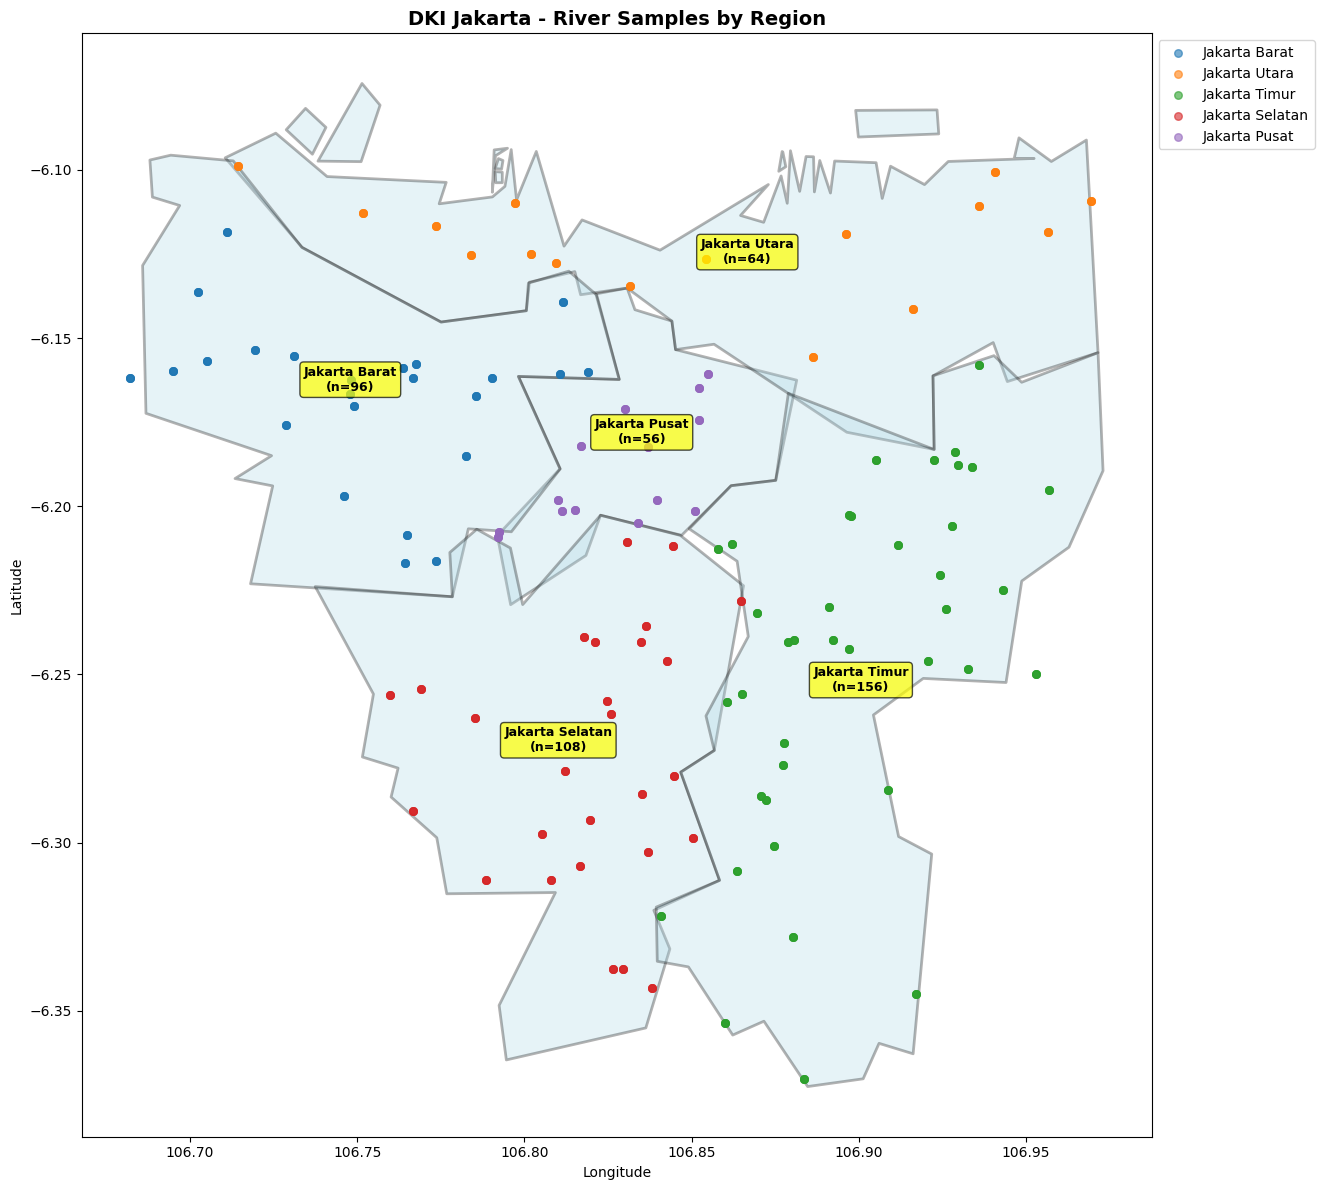

In [27]:
# Visualize regional assignments
fig, ax = plt.subplots(figsize=(14, 12))

# Plot boundaries
gdf_boundaries.plot(ax=ax, edgecolor='black', facecolor='lightblue', alpha=0.3, linewidth=2, aspect=None)

# Plot samples colored by region
for kota in gdf_sungai_with_region['kota_kabupaten'].unique():
    samples = gdf_sungai_with_region[gdf_sungai_with_region['kota_kabupaten'] == kota]
    samples.plot(ax=ax, markersize=30, alpha=0.6, label=kota.replace('Kota Administrasi ', ''))

# Add labels to boundaries
for _, row in gdf_boundaries.iterrows():
    centroid = row.geometry.centroid
    short_name = row['nama'].replace('Kota Administrasi ', '')
    count = (gdf_sungai_with_region['kota_kabupaten'] == row['nama']).sum()
    ax.annotate(text=f"{short_name}\n(n={count})", xy=(centroid.x, centroid.y), 
                ha='center', fontsize=9, weight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=True)
ax.set_title('DKI Jakarta - River Samples by Region', fontsize=14, weight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

In [40]:
sungai_df_with_region['tanggal'] = sungai_df_with_region['periode_data'].astype(str) + "-" + sungai_df_with_region['bulan_sampling'].astype(str) + "-15"

sungai_df_with_region['tanggal'] = pd.to_datetime(
    sungai_df_with_region['tanggal'], 
    format='mixed',
    dayfirst=False,
    errors='raise'
)

In [42]:
sungai_df_with_region.info()

<class 'pandas.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   periode_data            480 non-null    int64         
 1   bulan_sampling          480 non-null    int64         
 2   Amoniak                 480 non-null    float64       
 3   BOD                     480 non-null    float64       
 4   COD                     480 non-null    float64       
 5   Cd                      480 non-null    float64       
 6   Cr6                     480 non-null    float64       
 7   Cu                      480 non-null    float64       
 8   DO                      480 non-null    float64       
 9   F                       480 non-null    float64       
 10  Fenol                   480 non-null    float64       
 11  H2S                     480 non-null    float64       
 12  Hg                      480 non-null    float64       
 13  K

In [56]:
river_index_columns = ['tanggal', 'stasiun']
river_value_columns = ['Amoniak', 'BOD', 'COD', 'Cd', 'Cr6',
       'Cu', 'DO', 'F', 'Fenol', 'H2S', 'Hg', 'Klorida', 'Klorin Bebas',
       'Klorin Bebas n In Situ', 'MBAS', 'Minyak dan Lemak', 'Ni', 'Nitrat',
       'Nitrit', 'Pb', 'Sianida', 'Sulfat', 'Total N', 'Total P', 'Zn', 'pH',
       'TDS', 'TSS', 'Warna', 'Fecal Coliform', 'Total Coliform']

In [57]:
riverQ_df = sungai_df_with_region[river_index_columns + river_value_columns]

In [60]:
river_agg = riverQ_df.groupby(river_index_columns).agg({
    col: ['mean', 'median'] for col in river_value_columns
}).reset_index()

In [62]:
river_agg.columns = ['tanggal', 'stasiun'] + [f'{col} {stat}' for col in river_value_columns for stat in ['mean', 'median']]

In [64]:
river_agg.info()

<class 'pandas.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 64 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   tanggal                        20 non-null     datetime64[us]
 1   stasiun                        20 non-null     str           
 2   Amoniak mean                   20 non-null     float64       
 3   Amoniak median                 20 non-null     float64       
 4   BOD mean                       20 non-null     float64       
 5   BOD median                     20 non-null     float64       
 6   COD mean                       20 non-null     float64       
 7   COD median                     20 non-null     float64       
 8   Cd mean                        20 non-null     float64       
 9   Cd median                      20 non-null     float64       
 10  Cr6 mean                       20 non-null     float64       
 11  Cr6 median                     2

In [52]:
ispu2020_2024 = pd.read_csv("ISPU2020-2024.csv")
ispu2020_2024['tanggal'] = pd.to_datetime(
    ispu2020_2024['tanggal'], 
    format='mixed',
    dayfirst=False,
    errors='raise'
)

In [53]:
ispu2020_2024

,ID,periode_data,tanggal,stasiun,pm_sepuluh,sulfur_dioksida,karbon_monoksida,ozon,nitrogen_dioksida,max,parameter_pencemar_kritis,kategori
0,2020-01-01_DKI5,202001,2020-01-01,DKI5,38.0,36.0,25.0,46.0,9.0,46.0,O3,BAIK
1,2020-01-02_DKI5,202001,2020-01-02,DKI5,45.0,36.0,39.0,102.0,8.0,102.0,O3,TIDAK SEHAT
2,2020-01-03_DKI5,202001,2020-01-03,DKI5,51.0,37.0,27.0,63.0,10.0,63.0,O3,SEDANG
3,2020-01-04_DKI5,202001,2020-01-04,DKI5,51.0,38.0,19.0,85.0,10.0,85.0,O3,SEDANG
4,2020-01-05_DKI5,202001,2020-01-05,DKI5,52.0,39.0,25.0,62.0,9.0,62.0,O3,SEDANG
...,...,...,...,...,...,...,...,...,...,...,...,...
6130,2024-12-31_DKI4,202412,2024-12-31,DKI4,27.0,21.0,6.0,18.0,8.0,27.0,PM10,BAIK
6131,2024-12-31_DKI2,202412,2024-12-31,DKI2,29.0,22.0,11.0,12.0,13.0,35.0,PM25,BAIK
6132,2024-12-31_DKI1,202412,2024-12-31,DKI1,29.0,6.0,13.0,10.0,18.0,29.0,PM25,BAIK
6133,2024-12-31_DKI3,202412,2024-12-31,DKI3,29.0,6.0,13.0,10.0,18.0,29.0,PM10,BAIK


In [65]:
ispu_river_df = reduce(lambda left, right: pd.merge(left, right, on=['tanggal', 'stasiun'], how='outer'), [ispu2020_2024[ispu2020_2024['tanggal'] >= '2024-01-01'], river_agg])

In [69]:
ispu_river_df[[f'{col} {stat}' for col in river_value_columns for stat in ['mean', 'median']]] = (
    ispu_river_df.groupby('stasiun')[[f'{col} {stat}' for col in river_value_columns for stat in ['mean', 'median']]].transform(lambda x: x.bfill().ffill())
)

In [72]:
ispu_river_df

,ID,periode_data,tanggal,stasiun,pm_sepuluh,sulfur_dioksida,karbon_monoksida,ozon,nitrogen_dioksida,max,...,TDS mean,TDS median,TSS mean,TSS median,Warna mean,Warna median,Fecal Coliform mean,Fecal Coliform median,Total Coliform mean,Total Coliform median
0,2024-01-01_DKI1,202401,2024-01-01,DKI1,64.0,52.0,9.0,13.0,30.0,89.0,...,281.428571,252.0,105.214286,45.0,5.621429,3.5,7.587789e+05,295000.0,7.588574e+05,295000.0
1,2024-01-01_DKI2,202401,2024-01-01,DKI2,67.0,34.0,18.0,26.0,10.0,103.0,...,1503.375000,526.0,28.562500,23.0,3.287500,2.0,9.745378e+05,1260000.0,1.043200e+06,1600000.0
2,2024-01-01_DKI3,202401,2024-01-01,DKI3,65.0,14.0,54.0,13.0,34.0,89.0,...,239.851852,204.0,63.555556,30.0,2.966667,2.0,4.458864e+05,22000.0,4.506250e+05,22000.0
3,2024-01-01_DKI4,202401,2024-01-01,DKI4,74.0,10.0,20.0,24.0,10.0,110.0,...,287.589744,268.0,113.564103,38.0,2.905128,1.0,8.981798e+05,920000.0,1.026052e+06,1600000.0
4,2024-01-01_DKI5,202401,2024-01-01,DKI5,58.0,40.0,18.0,55.0,12.0,99.0,...,383.916667,364.0,29.791667,26.5,7.241667,7.0,2.282326e+05,17000.0,2.293809e+05,17000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819,2024-12-31_DKI1,202412,2024-12-31,DKI1,29.0,6.0,13.0,10.0,18.0,29.0,...,276.742857,298.1,38.297857,36.5,39.357143,30.5,1.851071e+06,1700000.0,3.311429e+06,3500000.0
1820,2024-12-31_DKI2,202412,2024-12-31,DKI2,29.0,22.0,11.0,12.0,13.0,35.0,...,1797.818750,594.8,38.000000,36.5,33.750000,32.5,2.165375e+06,1150000.0,3.866438e+06,1950000.0
1821,2024-12-31_DKI3,202412,2024-12-31,DKI3,29.0,6.0,13.0,10.0,18.0,29.0,...,199.888889,187.0,29.851852,24.0,24.814815,24.0,1.067093e+06,300000.0,2.253926e+06,900000.0
1822,2024-12-31_DKI4,202412,2024-12-31,DKI4,27.0,21.0,6.0,18.0,8.0,27.0,...,261.920513,266.5,36.384615,29.0,51.179487,33.0,1.086702e+07,2400000.0,1.473895e+07,2800000.0


=== Top Positive Correlations with Kategori ===
max                  0.735798
pm_sepuluh           0.536592
karbon_monoksida     0.212268
ozon                 0.201385
nitrogen_dioksida    0.187744
pH mean              0.175811
pH median            0.163249
Sianida median       0.152339
sulfur_dioksida      0.124994
Cd mean              0.120796
Sianida mean         0.120789
Cd median            0.119111
Nitrat mean          0.111413
MBAS median          0.105226
COD mean             0.096271
Name: kategori_encoded, dtype: float64

=== Top Negative Correlations with Kategori ===
Total N median                  -0.020199
periode_data                    -0.022205
Fecal Coliform mean             -0.027173
Total Coliform mean             -0.029151
Nitrit median                   -0.029455
Total P mean                    -0.032947
Minyak dan Lemak median         -0.036522
Total P median                  -0.040886
TSS median                      -0.056437
Hg median                       -0.0

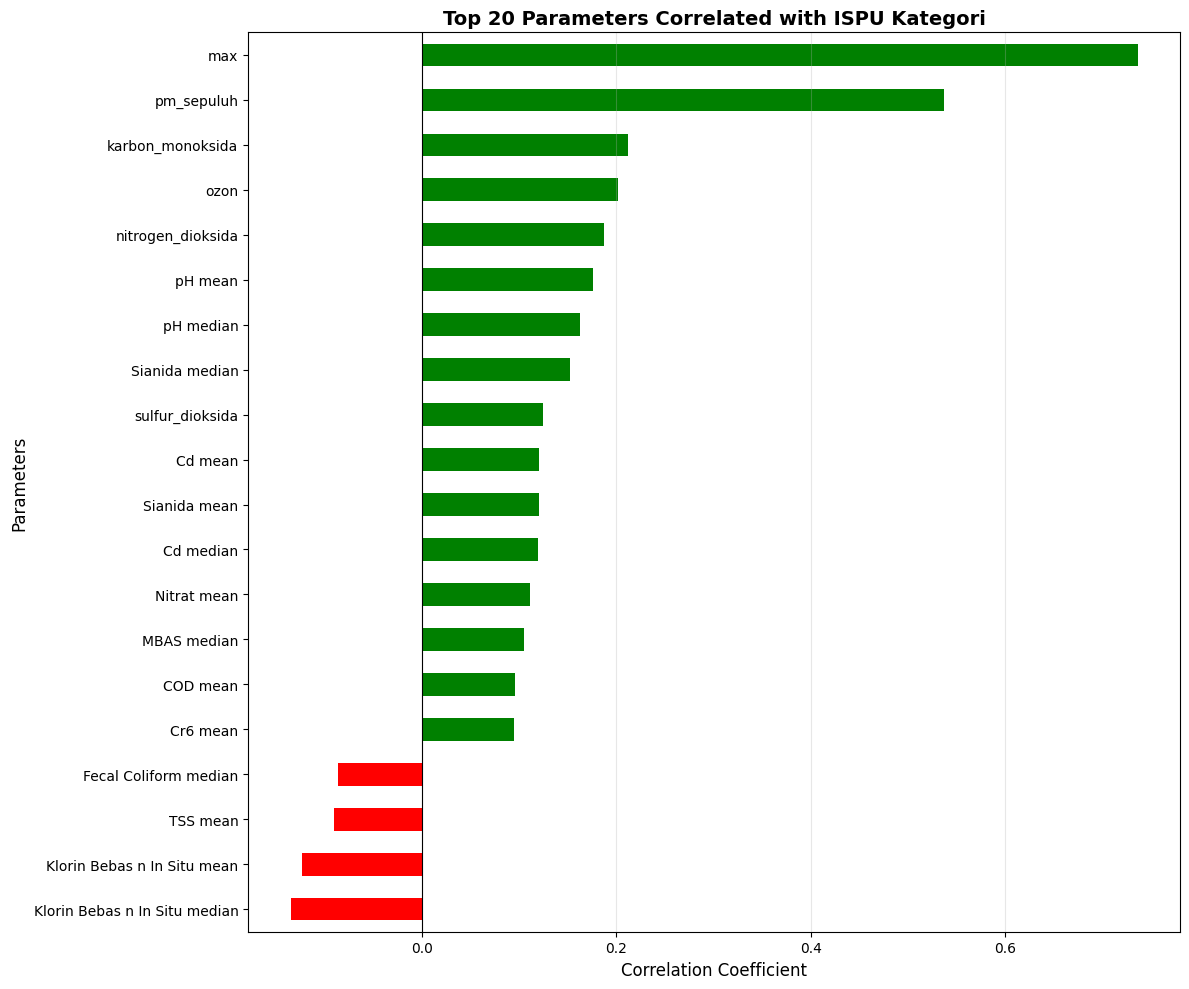

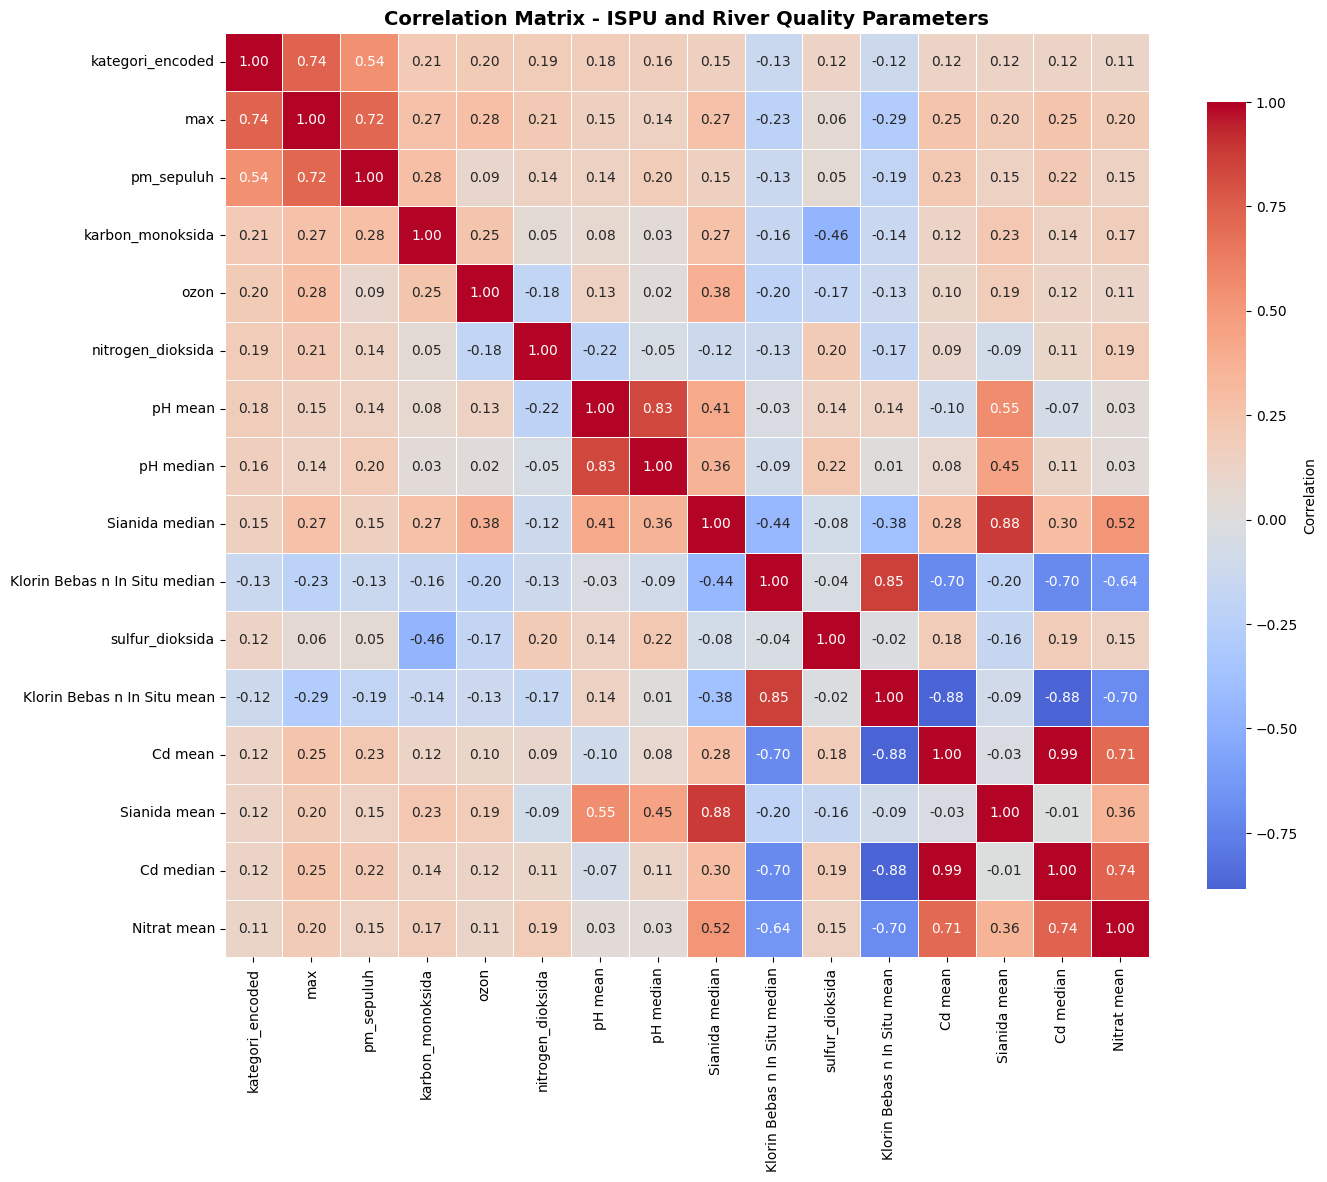

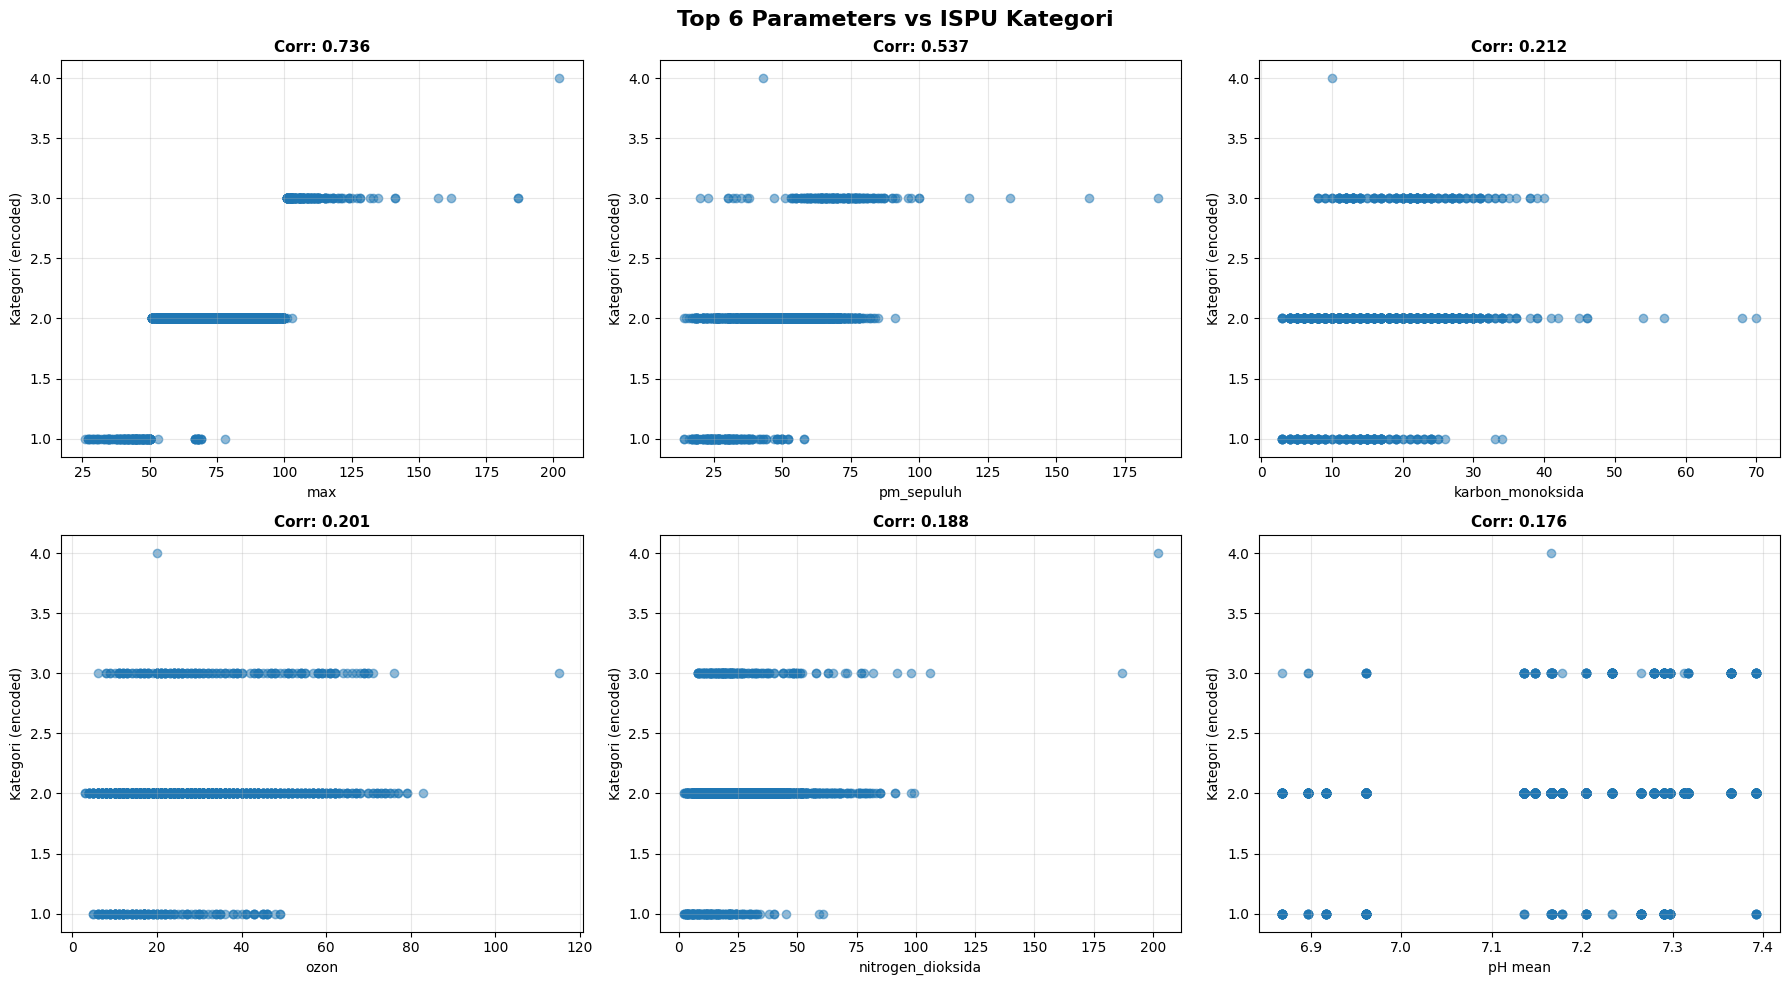

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Encode 'kategori' to numeric values
# Typical ISPU categories: BAIK < SEDANG < TIDAK SEHAT < SANGAT TIDAK SEHAT < BERBAHAYA
kategori_mapping = {
    'BAIK': 1,
    'SEDANG': 2,
    'TIDAK SEHAT': 3,
    'SANGAT TIDAK SEHAT': 4,
    'BERBAHAYA': 5
}

# Create a copy with encoded kategori
df_encoded = ispu_river_df.copy()
df_encoded['kategori_encoded'] = df_encoded['kategori'].map(kategori_mapping)

# Select only numeric columns including the encoded kategori
numeric_cols = df_encoded.select_dtypes(include=['number']).columns.tolist()

# Calculate correlation with kategori_encoded
correlations = df_encoded[numeric_cols].corr()['kategori_encoded'].sort_values(ascending=False)

# Display top correlations (excluding kategori_encoded itself)
print("=== Top Positive Correlations with Kategori ===")
print(correlations[correlations.index != 'kategori_encoded'].head(15))
print("\n=== Top Negative Correlations with Kategori ===")
print(correlations[correlations.index != 'kategori_encoded'].tail(15))

# Visualization 1: Bar plot of correlations with kategori
fig, ax = plt.subplots(figsize=(12, 10))
top_n = 20
top_correlations = correlations[correlations.index != 'kategori_encoded'].abs().sort_values(ascending=False).head(top_n)
correlation_values = correlations[top_correlations.index].sort_values()

colors = ['red' if x < 0 else 'green' for x in correlation_values]
correlation_values.plot(kind='barh', color=colors, ax=ax)
ax.set_xlabel('Correlation Coefficient', fontsize=12)
ax.set_ylabel('Parameters', fontsize=12)
ax.set_title(f'Top {top_n} Parameters Correlated with ISPU Kategori', fontsize=14, weight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization 2: Focused heatmap with kategori and top correlated features
top_features = correlations[correlations.index != 'kategori_encoded'].abs().sort_values(ascending=False).head(15).index.tolist()
focused_features = ['kategori_encoded'] + top_features
correlation_matrix_focused = df_encoded[focused_features].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_focused, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, 
            cbar_kws={"shrink": 0.8, "label": "Correlation"})
plt.title('Correlation Matrix - ISPU and River Quality Parameters', 
          fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

# Visualization 3: Scatter plots for top 6 correlated parameters
top_6_features = correlations[correlations.index != 'kategori_encoded'].abs().sort_values(ascending=False).head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_6_features):
    ax = axes[idx]
    df_plot = df_encoded.dropna(subset=[feature, 'kategori_encoded'])
    ax.scatter(df_plot[feature], df_plot['kategori_encoded'], alpha=0.5)
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('Kategori (encoded)', fontsize=10)
    ax.set_title(f'Corr: {correlations[feature]:.3f}', fontsize=11, weight='bold')
    ax.grid(alpha=0.3)

plt.suptitle('Top 6 Parameters vs ISPU Kategori', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()